# Mini-Challenge 1: Hyperparameter und Model Tuning 

In [1]:
import pandas as pd
import numpy as np
import random
import os
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split


from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from matplotlib.pyplot import figure

import time
import copy

## Ausgangslage:

Das Ziel diese Mini-Challenge ist es ein neuronales Netzwerk zu Implementieren, trainiern und zu validieren. Das Model sollte ein Klassifikationstask sein mit selbst vorgeschlagenem Datenset. Der Fokus der Mini-Challenge soll auf die Evaluation der Modellvarianten und Settings der Hyperparameter gelegt werden. Mit einem Srcaper habe ich von der Website https://unsplash.com/ tausende Bilder von 5 verschiedenen Tieren entnommen.

## 1. Daten kennenlernen

### 1.1 Volume

In [2]:
animals = ["bird","cat","dog","fish","horse"]
volume = []
print("Klassen:")
for animal in animals:
    folder_train="Data/train/"+animal
    folder_test="Data/test/"+animal
    list1 = os.listdir(folder_train)
    list2 = os.listdir(folder_test)
    number_files = len(list1) + len(list2)
    print(animal, number_files)
    volume.append(number_files)
    
print("\nInsgesammt haben wir {} Bilder.".format(sum(volume)))

Klassen:
bird 9785
cat 9961
dog 8123
fish 9403
horse 8940

Insgesammt haben wir 46212 Bilder.


Beispiel-Bilder vom Datensatz:


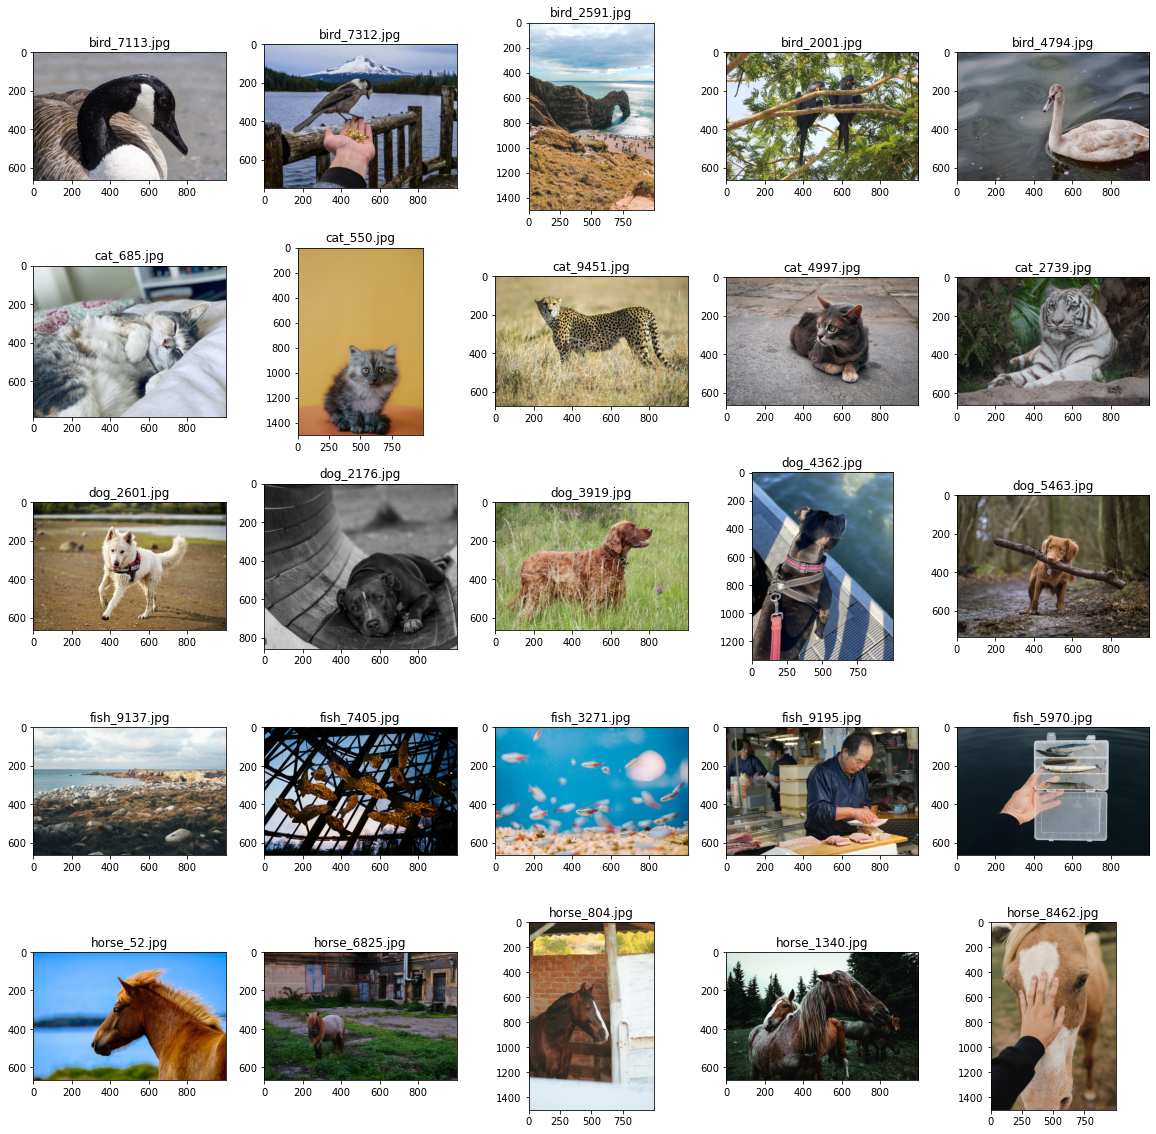

In [3]:
print("Beispiel-Bilder vom Datensatz:")
plt.figure(figsize=(20,20))
animals = ["bird","cat","dog","fish","horse"]
k = 0
random.seed(4)

for animal in animals:
    test_folder="Data/train/"+animal
    
    for i in range(5):
        file = random.choice(os.listdir(test_folder))
        image_path= os.path.join(test_folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(5,5,k+1)
        ax.title.set_text(file)
        plt.imshow(img)
        k = k+1    

##### Beobachtung:

+ Die Bilder haben eine hohe Auflösung
+ Die Tiere sind meistens gut erkennbar
- Tiere sind nicht immer zentriert
- Manchmal mehrere Objekte in einem Bild
- Fokus nicht immer beim Tier
- Unterschiedliche Formate

### 1.3 Preprocess and load Data

Die Bilder wurden in Train, Valid und Test aufgeteilt die in unterschiedlichen Ordnern lokal abgelegt worden sind.
Mit einer Funktion wollen wir auf den passenden Ordner zugreifen und mit einer definierten Batch_size reinladen. Im gleichen Schritt wollen wir die Bilder einheitlich skallieren (resize) und normalisieren. Das Normalisieren hilft, dass der CNN besser performt.
Die Auswahl der Grösse der Bilder hängt stark mit dem Netwerk und dem GPU zusammen mit dem man arbeitet. Für den Anfang werden wir die Bilder runter skalieren auf eine Dimension von 32x32.

In [4]:
def image_loader(image_size=32, batch_size=4, root="Images/",num_workers=2,shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = torchvision.datasets.ImageFolder(root=root, transform=transform)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data_loader

classes = ("bird","cat","dog","fish","horse")

In [5]:
train_path='Data/train/'
test_path='Data/test/'
batch_size = 32

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

## 2. Define the Modell

### 2.1 Metrics

Zu Beginn visualisieren wir eine Konfusionsmatrix und können sehen, wie sich das Modell verhält und welche Werte sich ergeben. Daraus leiten wir dann die folgenden Metriken ab und können die verschiedenen Modelle vergleichen.

$$Precision = \frac{TP} {TP+FP}$$

$$Recall = \frac{TP} {TP+FN}$$

$$F_1 =\big{(}\frac{1/Precision+1/Recall} {2}\big{)}^{-1}$$

Precision wird wie in der oben gezeigte Gleichung berechnet und gibt den Anteil der korrekt vorhergesagten positiven Ergebnisse (TP) im Verhältnis zur Summe aller  positiv vorhergesagten Ergebnisse (P) an.
Der Recall gibt den Anteil der korrekt als positiv eingestuften Ergebnisse (TP) an der Gesamtheit der tatsächlich positiven Ergebnisse (P) an. Der F1-Score ist die harmonische Mitte aus Precision und Recall und wird oft als zusammenfassende Metrik verwendet. Daher werden wir hauptsächlich F1-Score als unsere Metrik für den vergleich unterschiedlicher Modelle verwenden.

Zudem werden wir beim trainiren der Modelle mit Accuracy und Mean absolute error (L1 Loss) arbeiten:

$$Accuracy = \frac{Anzahl richtige Vorhersagen} {Anzahl gemachte Vorhersagen}$$

$$MeanAbsoluteError = \frac{\sum_{i=1}^n|y_i-\hat{y}_i|} {n}$$






### 2.2 Basic functionality

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [15]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [10]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## 3. Training with SGD (without REG, without BN)

In [17]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, testloader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 52s
	Train Loss: 1.681 | Train Acc: 27.12%
	 Val. Loss: 1.550 |  Val. Acc: 28.65%
Epoch: 02 | Epoch Time: 5m 56s
	Train Loss: 1.480 | Train Acc: 35.25%
	 Val. Loss: 1.439 |  Val. Acc: 38.23%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb74bab49d0>
Traceback (most recent call last):
  File "/Users/Firat/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/Firat/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/Firat/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/Firat/opt/anaconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/Firat/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/Firat/opt/anaconda3/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
Keyboa

KeyboardInterrupt: 

In [104]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, testloader, criterion, device)

In [105]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.298 | Test Acc: 17.39%


In [64]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [65]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

In [66]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

In [68]:
from sklearn import metrics


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (10).

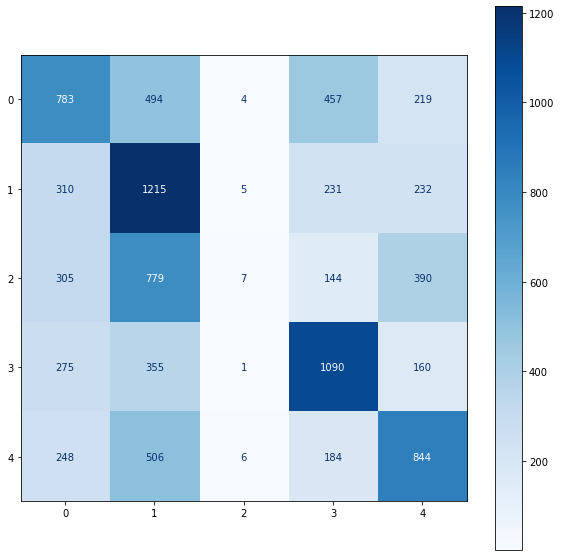

In [69]:
plot_confusion_matrix(labels, pred_labels)

In [70]:
corrects = torch.eq(labels, pred_labels)


In [71]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [74]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(32, 32).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

RuntimeError: shape '[32, 32]' is invalid for input of size 3072

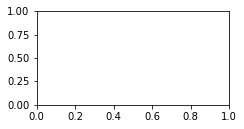

In [75]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

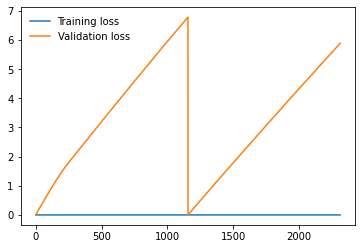

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [68]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


In [83]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [5]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

NameError: name 'trainloader' is not defined

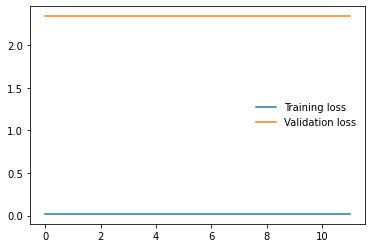

In [82]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

AttributeError: 'Net' object has no attribute 'history'

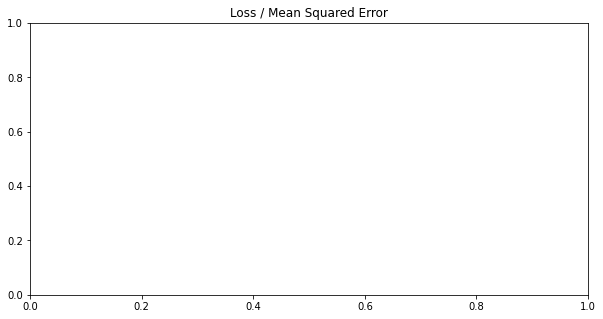

In [57]:
# plot loss during training
figure(figsize=(10, 5))
plt.title('Loss / Mean Squared Error')
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(X_train), type(X_train_tensor), X_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [39]:
X_train_tensor.shape

torch.Size([28, 3, 50, 50])

In [42]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [19]:
batch_size = 32
trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)

In [20]:
sample_data = iter(trainloader)
images, labels = sample_data.next()

In [33]:
images.shape

(32, 3, 50, 50)

In [22]:
images = (images.numpy())
labels = (labels.numpy())
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [23]:
X_train.shape

(28, 3, 50, 50)

In [24]:
X_test.shape

(4, 3, 50, 50)

In [36]:
X_train = X_train.reshape(X_train.shape[0],3*50*50)
X_test = X_test.reshape(X_test.shape[0],3*50*50)

In [14]:
sgd_clf = SGDClassifier(random_state=42) # instantiate
sgd_clf.fit(X_train, y_train) # train the classifier

SGDClassifier(random_state=42)

In [15]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# array([0.96485, 0.95 , 0.9494 ])
# We get accuracy for each fold = 96.45%, 95%, 94.94%

array([0.3       , 0.22222222, 0.33333333])

In [16]:
classes = ["bird","cat","dog","fish","horse"]

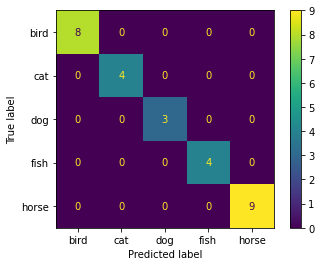

In [17]:
plot_confusion_matrix(sgd_clf, X_train, y_train,display_labels=classes)
plt.show()

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

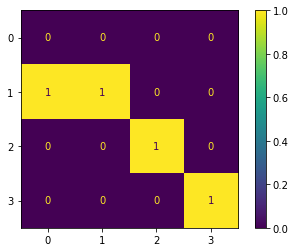

In [18]:
plot_confusion_matrix(sgd_clf, X_test, y_test,display_labels=classes)
plt.show()

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [23]:
precision_score(y_train, y_train_pred,average="macro")

0.30046633014948565

In [24]:
recall_score(y_train, y_train_pred,average="macro")

0.2941145348875628

In [ ]:
import torch

# andere test:

In [19]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

In [2]:
import torch

In [29]:
X_train = torch.FloatTensor([0., 1., 2.])
X_train.is_cuda

False

In [27]:
torch.cuda.is_available()

False

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [190]:
# define model
model = Sequential()
model.add(Dense(250, input_dim=7500, activation='relu', kernel_initializer='he_uniform'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)

In [191]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

In [192]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 1.416, Test: 2.096


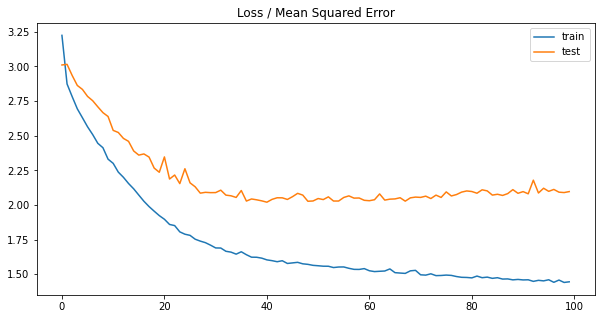

In [193]:
# plot loss during training
figure(figsize=(10, 5))
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 4. Benefits of Regularization

### 4.1 Different regularization methods

### 4.2 Evaluation

## 5  Benefits of Batchnorm BN (without REG, with SGD)

## 6.  Benefits of Adam (without BN, without/with REG)

### 5.1 Evaluation

### 5.2 Interpretieren